<a href="https://colab.research.google.com/github/EddyGiusepe/Studying_Transfer_Learning/blob/main/CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">CNN - Transfer Learning</h2>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este estudo foi baseado no seguinte [blog do Sensio](https://juansensio.com/blog/044_cnn_transfer_learning).


# Transfer Learning em Redes Neurais Convolucionais (CNN)

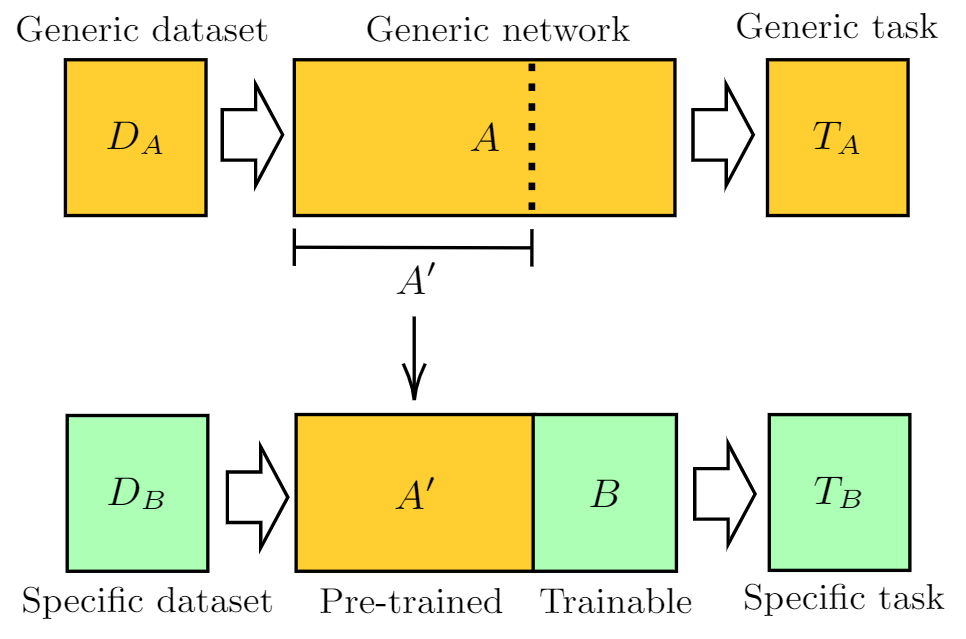

Objetivo:

* Aprender a aplicar a técnica Transfer Learning. Neste caso, vamos a usar uma Rede Neural Pre-treinada em ``Imagenet``, e vamos a adaptar-a para uma nova tarefa de classificação num pequeno Dataset.
 
* Aqui, entrenaremos um classificadores de flores.

Resumo:

Aqui você aprenderá a usar ``TRANSFER LEARNING`` com Redes Neurais Convolucionais (CNN). Aplicar está técnica nos permitirá obter melhores modelos com menos requisitos computacionais e com Datasets reduzidos. Podemos descarregar uma rede pre-treinada com outro Dataset (idealmente, um Dataset similar ao nosso) e aproveitar o máximo número de capas. Podemos congelar a red pre-treinada, de maneira que não se atualizem seus pesos durante o treinamento, e utiilizar-a apenas como extractor de características que as novas capas (as quais sim treinamos) podem aproveitar. Ainda assim, realizar um ``fine tuning`` (seguir treinando a rede pre-treinada) pode dar como resultado um melhor modelo. O ``Transfer Learning`` é uma técnica muito poderosa (sempre que possamos usar) que podemos aproveitar para reduzir os requisitos computacionais de nossos modelos.  

# Importamos as nossas bibliotecas

In [2]:

import random 
from skimage import io
import matplotlib.pyplot as plt



In [ ]:
!pip install wget

# Nosso Dataset

In [4]:
# Descarregamos o Dataset
# !pip install wget

import wget 

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [5]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
import os 

PATH = 'flowers'

classes = os.listdir(PATH)

print("Observamos que temos 5 classes de flores diferentes: ")
print("")
classes

Observamos que temos 5 classes de flores diferentes: 



['rose', 'tulip', 'dandelion', 'daisy', 'sunflower']

In [7]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: rose. Imágenes: 784
Categoría: tulip. Imágenes: 984
Categoría: dandelion. Imágenes: 1055
Categoría: daisy. Imágenes: 769
Categoría: sunflower. Imágenes: 734


# Visualizamos nossos Dados

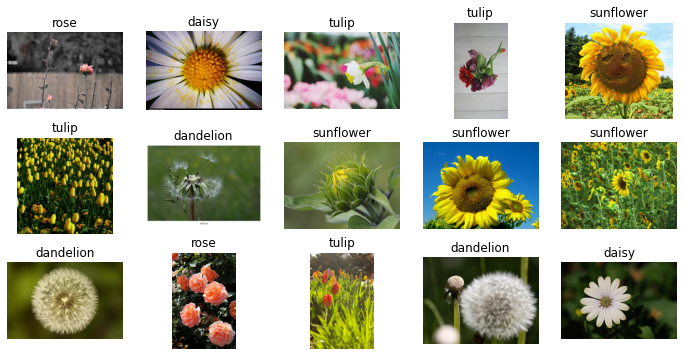

In [8]:
# Visualizamos algumas imagens:

fig, axs = plt.subplots(3,5, figsize=(12,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

# Dados de Treino e Teste

In [9]:
# Em primeiro lugar vamos a treinar nosso modelo desde zero para observar que métricas obtemos:

# Separamos em Dados de treinamento e teste

from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])



In [11]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

# Nossos Dados redimensionado

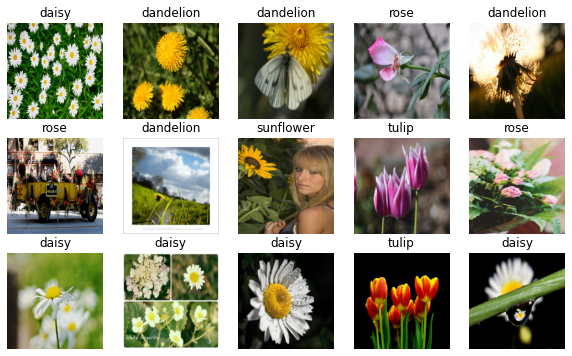

In [12]:
# Aqui verificamos que o tamanho de todas as imagens sejam de 224x224:

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

# Nosso Modelo

Vamo escolher a ARQUITETURA  ``resnet``, para criar nosso classificador.Deste modelo usamos todas as capas <font color="yellow">excepto a última</font>, a qual substituíremos por uma capa linear para levar a cabo a classificação em $5$ classes.  

In [14]:
import torchvision

resnet = torchvision.models.resnet18()  # 18 capas, mais rápido de entrenar
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Uma pequena descrição da primeira capa:

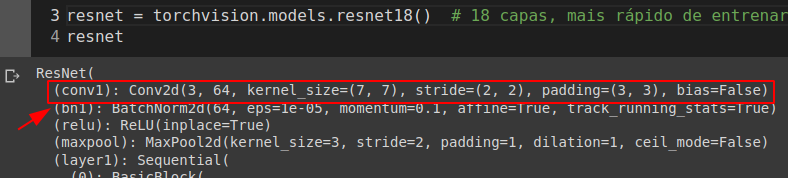

```
Conv2d(3, 64, kerner_size=(7, 7), stride = ...)
```
* 3 --> são os número de canais (nossas imagens são em cor, então tem três canais)

* 64 --> Vai aplicar 64 filtros de 7x7 (kerner_size=(7, 7))


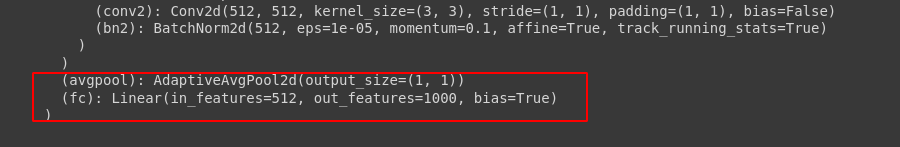

Só vamos a modificar ``out_features``, já que nossa sálida é para $5$ classes.

```
(fc): Linear(in_features=512, out_features=1000, bias=True)
```

``in_features = 512`` ficara igual (não modificamos ela não) já que é a saída da CNN.

In [15]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1]) # [:-1] menos a última
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False # False --> Camadas congeladas (já foram treinadas)
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x) # Aqui recebe a capa linear "torch.nn.Linear(512, 5)"
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [16]:
model = Model()
# Passamos um tensor de prova (para verificar o funcionamento mesmo)
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [17]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

# Treinamento desde zero

Neste primeiro teste, treinamos desde zero para ver que métricas fornece.

In [ ]:
model = Model()

fit(model, dataloader, epochs=15)

Como se pode observar as métricas tem valores ruins... isso é normal porque temos poucos Dados.

# Transfer Learning

<font color="orange">Agora vamos treinar o mesmo caso mas, neste caso, utilizando os PESOS PRE-TREINADOS de ``resnet``.</font>

In [19]:
model = Model(pretrained=True, freeze=True) 
# pretrained=True --> Usamos a rede resnet JÁ TREINADA
# freeze=True --> Não vamos a treinar a rede resnet, só vamos treinar a última capa.

fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 1.05433 val_acc 0.57402: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 1/5 loss 1.05151 val_loss 1.05433 acc 0.63835 val_acc 0.57402


val_loss 0.75304 val_acc 0.73749: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 2/5 loss 0.65859 val_loss 0.75304 acc 0.79830 val_acc 0.73749


val_loss 0.64027 val_acc 0.78385: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 3/5 loss 0.54513 val_loss 0.64027 acc 0.83239 val_acc 0.78385


val_loss 0.65589 val_acc 0.76111: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 4/5 loss 0.46979 val_loss 0.65589 acc 0.85284 val_acc 0.76111


val_loss 0.60105 val_acc 0.79096: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Epoch 5/5 loss 0.44469 val_loss 0.60105 acc 0.85852 val_acc 0.79096


Como podemos ver: Obtemos um melhor modelo em menos epoch e cada época tarde menos tempo. Isto é devido a que, não treinamos toda a rede, os requisitos computacionais se reduzem consideravelmente. Melhores modelos e treinados mais rápido.

# Fine Tuning

Ainda podemos melhorar um pouco mais se, ademais de utilizar os pesos descarregados de Imagenet em ``resnet``, treinamos também a rede completa.

In [20]:
model = Model(pretrained=True, freeze=False) # freeze=False --> Observa que temos FALSE!!!: 
fit(model, dataloader)

val_loss 0.72700 val_acc 0.70374: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 1/5 loss 0.80036 val_loss 0.72700 acc 0.74574 val_acc 0.70374


val_loss 0.70362 val_acc 0.70428: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 2/5 loss 0.38333 val_loss 0.70362 acc 0.89006 val_acc 0.70428


val_loss 1.02786 val_acc 0.60733: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 3/5 loss 0.28589 val_loss 1.02786 acc 0.90597 val_acc 0.60733


val_loss 0.41074 val_acc 0.85232: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 4/5 loss 0.20642 val_loss 0.41074 acc 0.94006 val_acc 0.85232


val_loss 0.35906 val_acc 0.87274: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

Epoch 5/5 loss 0.14737 val_loss 0.35906 acc 0.96108 val_acc 0.87274


É muito comum treinar primeiro o MODELO sem treinar a REDE PRE-TREINADA durante várias épocas e depois seguir treinando, mas permitindo agora a ATUALIZAÇÃO de PESOS também na REDE PRE-TREINADA (usualmente com um LEARNING RATE mais PEQUENO)

In [21]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

val_loss 1.90511 val_acc 0.30912: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 1/5 loss 1.07555 val_loss 1.90511 acc 0.61790 val_acc 0.30912


val_loss 0.79406 val_acc 0.68659: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 2/5 loss 0.65470 val_loss 0.79406 acc 0.80795 val_acc 0.68659


val_loss 0.86343 val_acc 0.65703: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 3/5 loss 0.55125 val_loss 0.86343 acc 0.82131 val_acc 0.65703


val_loss 1.13666 val_acc 0.54176: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 4/5 loss 0.49147 val_loss 1.13666 acc 0.83352 val_acc 0.54176


val_loss 0.97652 val_acc 0.62124: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 5/5 loss 0.46661 val_loss 0.97652 acc 0.84886 val_acc 0.62124


val_loss 0.79053 val_acc 0.68828: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 1/5 loss 0.87547 val_loss 0.79053 acc 0.63807 val_acc 0.68828


val_loss 0.63803 val_acc 0.75186: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 2/5 loss 0.64767 val_loss 0.63803 acc 0.74744 val_acc 0.75186


val_loss 0.55531 val_acc 0.79529: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 3/5 loss 0.55725 val_loss 0.55531 acc 0.79375 val_acc 0.79529


val_loss 0.51344 val_acc 0.81803: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 4/5 loss 0.48100 val_loss 0.51344 acc 0.82983 val_acc 0.81803


val_loss 0.51219 val_acc 0.81740: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

Epoch 5/5 loss 0.48800 val_loss 0.51219 acc 0.83239 val_acc 0.81740


Outra alternativa de ``fine tuning`` é a de treinar o modelo com diferentes LEARNING RATES, um para a REDE PRE-TREINADA e outro para as capas novas.

In [22]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])